In [1]:
import json
import numpy as np
import random

from lttb import LTTB

from env import Unlock

from tqdm import tqdm, trange
from itertools import product as Prod

# ============= TEST FUNCTION =================
def test (lttb, env, testset, par):
    rt, rb = r = (par['rt'], par['rb'])
    size = np.shape(testset)[-1]

    hist = {'agent'  : np.zeros ((size, par['T'], 2)),
            'action' : np.zeros ((size, par['T'], par['O'])),
            'theta'  : np.zeros (size),
            'R'      : np.zeros (size)}

    tars = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in testset])
    btns =  [(0., rb)] * len (testset)

    for i, (targ, btn) in enumerate (zip (tars, btns)):
        env.reset (init = init, targ = targ, btn = btn)
        lttb.initialize(par)
        R = 0

        state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

        for t in range (par['T']):
            action, _ = lttb.step (apicalFactor =0)
            state, r, done, agen = env.step (action)

            R = max (R, r)

            hist['action'][i, t] = action
            hist['agent'][i, t]  = agen

            if done: break

        hist['action'][i, t:] = np.nan
        hist['agent'][i, t:]  = agen
        hist['theta'][i]      = testset[i]
        hist['R'][i]          = R

    return hist

In [2]:
"""
sigma_in = 5
!!! -> fare test su tutti angoli 0-360, calcolare R come distanza minima tra bottone e array posizioni, poi fare plot e
   sovrapporre angoli di training
-> sparsificare l'input e/o il contesto
-> provare reaching studiando di piu' o diminuendo il numero di esempi (n_context=20 usato in due punti diversi del codice)
-> l'esperto raggiunge il bottone sempre a t=60, ovunque il bottone sia; questo implica velocita' diverse;
   possiamo o settare la velocita' ad una costante, quindi cambiando il tempo di reach del bottone, o semplicemente estrarre
   i bottoni su una circonferenza di raggio fissato
"""

"\nsigma_in = 5\n!!! -> fare test su tutti angoli 0-360, calcolare R come distanza minima tra bottone e array posizioni, poi fare plot e\n   sovrapporre angoli di training\n-> sparsificare l'input e/o il contesto\n-> provare reaching studiando di piu' o diminuendo il numero di esempi (n_context=20 usato in due punti diversi del codice)\n-> l'esperto raggiunge il bottone sempre a t=60, ovunque il bottone sia; questo implica velocita' diverse;\n   possiamo o settare la velocita' ad una costante, quindi cambiando il tempo di reach del bottone, o semplicemente estrarre\n   i bottoni su una circonferenza di raggio fissato\n"

In [3]:
# Loading configuration file
path = 'config.json'
config = 'BUTTON_FOOD'

n_examples = 3

with open (path, 'r') as f:
    par = json.load (f)[config]

par['hint'] = par['hint'] == 'True'
par['clump'] = par['clump'] == 'True'
par['validate'] = par['validate'] == 'True'
par['verbose'] = par['verbose'] == 'True'

# ==== Environment Initialization ======
init = np.array ((0., 0.))
targ = np.array ((0., 1.))
btn = np.array ((0., 0.))

env = Unlock (init = init, targ = targ, btn = btn, unit = (par['dt'], par['dx']), res = 20)

rt, rb = par['rt'], par['rb']

trainset = np.array (par['trainset'])
validset = np.array (par['validset'])
testset  = np.linspace (*par['testset'])

train_theta = trainset * np.pi / 180.
valid_theta = validset * np.pi / 180.
test_theta  = testset * np.pi / 180.

#train_targs = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in train_theta])

train_targs = (np.random.rand(n_examples,2)-.5)*2#np.array ([( np.random.rand(1) , np.random.rand(1) ) for t in train_theta])
train_thetas = [random.random()*2*np.pi for i in range(n_examples)]
train_bttns = np.array ([(1 * np.cos (t), 1 * np.sin (t)) for t in train_thetas])
#train_bttns = (np.random.rand(20,2)-.5)*2#np.array ([(0, rb) for t in train_theta])

#valid_targs = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in valid_theta])


In [4]:
np.shape(train_targs)

(3, 2)

In [5]:

#valid_bttns = np.array ([(rb * np.cos (t), rb * np.sin (t)) for t in valid_theta])

tb = 60
tf = 60

# Here we ask the env for the expert behaviour
epar = {'offT' : (1, 1), 'steps' : (tb-1, tf-1), 'T' : (tb, tf)}
train_exp = [env.build_expert (targ, init, btn, **epar) for targ, btn in zip (train_targs, train_bttns)]
#valid_exp = [env.build_expert (targ, init, btn, **epar) for targ, btn in zip (valid_targs, valid_bttns)]



In [6]:
train_bttns

array([[-0.20508999, -0.97874312],
       [ 0.94279648,  0.33336885],
       [-0.9391841 ,  0.34341406]])

In [7]:
import numpy as np

import matplotlib.pyplot as plt

from tqdm import trange
import random


N, I, O, T = 500, 80, 2, tb+tf
shape = (N, I, O, T)

dt = .001
tau_m = 20. * dt
tau_s = 2. * dt
tau_ro = 10. * dt
tau_star = 20. * dt
tau_W = 200 * dt


beta = np.exp(-dt/tau_s)
beta_ro = np.exp(-dt/tau_ro)
beta_targ = np.exp(-dt/tau_star)
beta_W = np.exp(-dt/tau_W)

sigma_context = 40.
sigma_targ = 0.#10**1.5
sigma_in = 20.#12.

dv = 1 / 500.
alpha = .005
alpha_rout = .01
Vo = - 4
h = - 1
s_inh = 20

sigma_Jrec = 0.
sigma_wrec = 0.
sigma_Jout = 0.1

Ne = 400
Ni = 100

N = Ne+Ni

n_contexts = n_examples

# Here we build the dictionary of the simulation parameters
par = {'dt' : dt, 'tau_m' : tau_m, 'tau_s' : tau_s, 'tau_ro' : tau_ro, 'tau_star' : tau_star,'tau_W' : tau_W,
       'dv' : dv, 'Vo' : Vo, 'h' : h, 's_inh' : s_inh,
       'N' : N, 'Ni' : Ni, 'Ne' : Ne, 'T' : T, 'I' : I, 'O' : O, 'shape' : shape, 
       'sigma_Jrec' : sigma_Jrec,'sigma_wrec' : sigma_wrec, 'sigma_Jout' : sigma_Jout,  'n_contexts' : n_contexts,
       'alpha' : alpha, 'alpha_rout' : alpha_rout,
       'sigma_in' : sigma_in, 'sigma_targ' : sigma_targ, 'sigma_context' : sigma_context, 'h' : h}

TIME = 1.

T = int(np.floor(TIME/dt))

nStepOutTraining = 1000

t_shut = 2

JMAX = 100.
nu_targ = 0.005

# Here we init our (recurrent) agent
lttb = LTTB (par)


In [8]:
# define clock and target

lttb.y_targ_collection = []
lttb.I_clock_collection = []

for k in range(n_contexts):
    
    lttb.y_targ_collection.append(train_exp[k][1])
    lttb.I_clock_collection.append( train_exp[k][0] )
    


In [9]:
"""
for k in range(n_contexts):

    plt.figure()
    plt.subplot(311)
    plt.plot(np.array(lttb.y_targ_collection[k]).T)
    plt.ylabel('$y_{targ}$')
    plt.subplot(212)
    plt.plot(np.array(lttb.I_clock_collection[k]).T)
    plt.xlabel('time(s)')
    plt.ylabel('clock')
"""

"\nfor k in range(n_contexts):\n\n    plt.figure()\n    plt.subplot(311)\n    plt.plot(np.array(lttb.y_targ_collection[k]).T)\n    plt.ylabel('$y_{targ}$')\n    plt.subplot(212)\n    plt.plot(np.array(lttb.I_clock_collection[k]).T)\n    plt.xlabel('time(s)')\n    plt.ylabel('clock')\n"

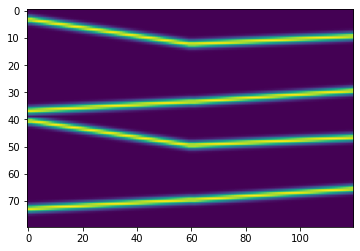

In [10]:
plt.imshow(np.array(lttb.I_clock_collection[2]))


In [11]:
## Training Rec
par['T'] = 120
lttb.T = 120
    
gamma = 10.
def f(x,gamma):
    return np.exp(x*gamma)/(np.exp(x*gamma)+1)
#f1 = @(x)(gamma*exp(gamma*x))./(exp(gamma*x)+1)-(gamma*exp(2*gamma*x))./(exp(gamma*x)+1).^2;

apicalFactorTrain = 1
apicalFactorTest = 0

nIterRec = 50

eta = 0.
eta_out = 0.01
etaW = .0

##############################

SR_list = []

for cont_index in range(n_contexts):
        
        lttb.initialize(par)
        lttb.y_targ = lttb.y_targ_collection[cont_index]
        lttb.I_clock = lttb.I_clock_collection[cont_index]
        
        lttb.cont = lttb.cont*0
        lttb.cont[0] = 1

        #for t in range(lttb.T-2):
        for t in range(tb):
            
            if t == tb:
                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1
                
            lttb.step(apicalFactor = apicalFactorTrain)
            
            SR = lttb.B_filt[:,t+1]#lttb.S_filtRO[:,t+1]#
        SR_list.append(lttb.B_filt)
        
            

            

In [12]:
np.shape(SR_list[0])

(500, 120)

In [14]:
#####################################
            
test_every = 5

ERRORS = np.zeros((int(nIterRec/test_every),n_contexts))
for iteration in range(nIterRec):
    
    ###### Online-Training

    #initialize simulation
    
    for cont_index in range(n_contexts):
        
        
        lttb.y_targ = lttb.y_targ_collection[cont_index]
        
        #ON-LINE
        """
        
        lttb.initialize(par)
        
        lttb.I_clock = lttb.I_clock_collection[cont_index]
        
        lttb.cont = lttb.cont*0
        lttb.cont[0] = 1
        
        #run simulation
        dH = 0

        #for t in range(lttb.T-2):
        for t in range(tb-2):
            
            if t == tb:
                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1
                
            lttb.step(apicalFactor = apicalFactorTrain)
            
            SR = lttb.B_filt[:,t+1]#lttb.S_filtRO[:,t+1]#
            Y = lttb.Jout@SR
            DJRO = np.outer(lttb.y_targ[:,t+1] - Y,SR.T)
            lttb.Jout =  lttb.Jout + eta_out*DJRO
        
        """
        #OFF-LINE
        
        SR = SR_list[cont_index]
        Y = lttb.Jout@SR
        DJRO = (lttb.y_targ[:,1:-1] - Y[:,0:-2]) @ ( SR.T[0:-2])
        lttb.Jout =  lttb.Jout + eta_out*DJRO
        
       
        
    ###### Test
    
    if iteration%test_every==0:

        for cont_index in range(n_contexts):
            
            lttb.initialize(par)
            lttb.y_targ = lttb.y_targ_collection[cont_index]
            lttb.I_clock = lttb.I_clock_collection[cont_index]
            
            
            lttb.cont = lttb.cont*0
            lttb.cont[0] = 1

            #run simulation

            #for t in range(lttb.T-2):
            for t in range(tb-2):
                
                if t==tb:
                    lttb.cont = lttb.cont*0
                    lttb.cont[1] = 1
                
                lttb.step(apicalFactor = apicalFactorTest)

            SR = lttb.B_filt[:,1:-2]#lttb.S_filtRO[:,1:-2]# 
            Y = lttb.Jout@SR
            mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2

            ERRORS[int(iteration/test_every),cont_index] = mse_rec_train

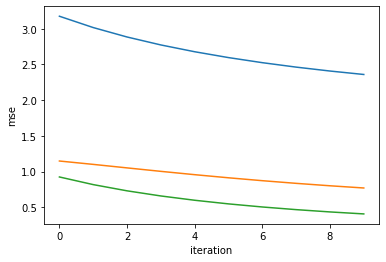

In [15]:
plt.figure()
plt.plot(ERRORS)
plt.xlabel("iteration")
plt.ylabel("mse")
plt.show()

In [16]:
np.shape(SR)



(500, 120)

In [17]:
np.shape(lttb.y_targ)



(2, 120)

In [18]:
lttb.T

120

2.941233389199893


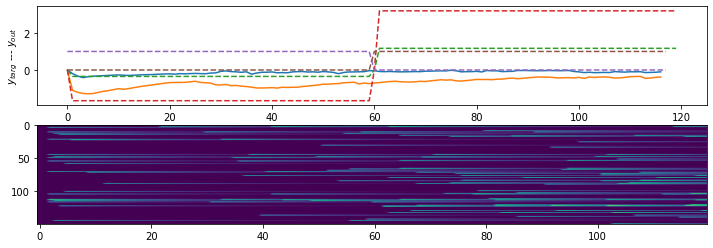

0.796048343259173


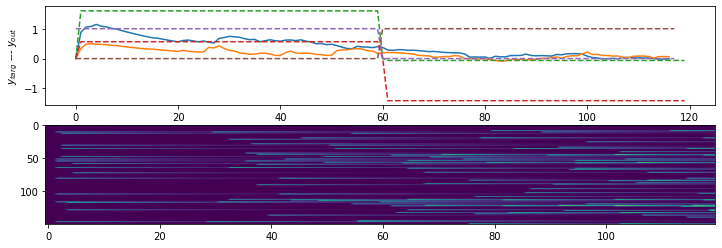

0.44312308348150403


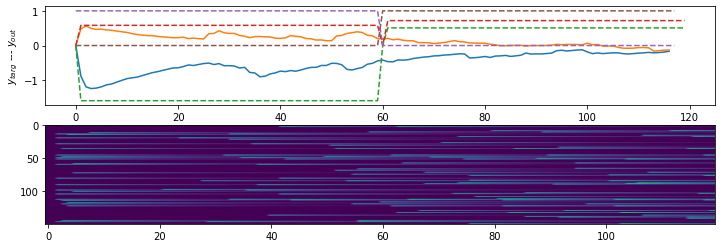

In [19]:
for cont_index in range(n_contexts):
    
    context = []

    lttb.initialize(par)
    lttb.I_clock = lttb.I_clock_collection[cont_index]
    lttb.y_targ = lttb.y_targ_collection[cont_index]
    
    lttb.cont = lttb.cont*0
    lttb.cont[0] = 1

    #run simulation
    
    apicalFactor = 0
    
    lttb.cont = lttb.cont*0
    lttb.cont[0] = 1

    for t in range(lttb.T-2):
 
        if t==tb:
           
            lttb.cont = lttb.cont*0
            lttb.cont[1] = 1
        context.append(lttb.cont)
        
        lttb.step(apicalFactor = apicalFactor)

    SR = lttb.B_filt[:,1:-2]#lttb.S_filtRO[:,1:-2]#
    Y = lttb.Jout@SR
    mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2

    print(mse_rec_train)
    
#mse, Y = lttb.train_ro(par,out_epochs = 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(211)
    plt.plot(Y.T)
    plt.plot(lttb.y_targ.T,'--')
    plt.plot(np.array(context),'--')
    
    plt.xlabel('time(s)')
    plt.ylabel('$y_{targ}$ --- $y_{out}$')
    plt.subplot(212)
    plt.imshow(lttb.B_filt[0:150,:],aspect='auto')
    #plt.plot(lttb.B_filt_rec.T)
    
    #plt.subplot(313)
    #plt.imshow(lttb.S_wind[0:20,:],aspect='auto')
    
    plt.show()

In [20]:
def make_test(btn_theta, show_plot=True):
    
    TIME_TEST = 1500

    par['T'] = TIME_TEST
    lttb.T = TIME_TEST
    lttb.initialize(par)

    lttb.y_targ = np.zeros((lttb.O,lttb.T))

    #targ_test = train_targs[cont_index]
    #btn_test = train_bttns[cont_index]

    #theta = 30
    #theta = theta/180*np.pi
    targ_test = (np.random.rand(2)-.5)
    #btn_test = (np.random.rand(2)-.5)
    
    btn_radius = 0.1
    btn_dist = 1.0
    btn_test = (btn_dist * np.cos (btn_theta), btn_dist * np.sin (btn_theta))
    btn = btn_test
    
    trajectory = np.zeros((2,TIME_TEST-1))
    trajectory[:,0] = init

    env.reset (init = init, targ = targ_test, btn = btn_test)

    agen = init

    R = 0

    ACTIONS = []
    POSITION = []#np.zeros((2,TIME_TEST-2))

    state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

    #lttb.I_clock[:,0] *= 0

    #state, r, done, agen = env.step ([0,0])
    lttb.I_clock[:,0] = state#lttb.I_clock_collection[cont_index][:,0]

    lttb.cont = lttb.cont*0
    lttb.cont[0] = 1

    closed_loop = 1

    context = []

    btn_on=0

    for t in range (TIME_TEST-2):

        if closed_loop:
            lttb.I_clock[:,lttb.t+1] = state
            if np.sqrt( np.sum((agen - btn_test)**2) ) < btn_radius:

                btn_on=1

                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1

        else:
            lttb.I_clock[:,lttb.t+1] = lttb.I_clock_collection[cont_index][:,lttb.t+1]
            if t == tb:
                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1

        context.append(lttb.cont)

        lttb.step (apicalFactor = 0)
        action = lttb.Jout@lttb.B_filt[:,t]
        ACTIONS.append(action)

        state, r, done, agen = env.step (action)

        #POSITION[:,t] = agen
        POSITION.append( list(agen) )

        R = max (R, r)

        if np.sqrt( np.sum((agen - targ_test)**2) )  < 0.1 and btn_on==1:
            done = 1

        if done: break


    min_btn_dist = min([np.sqrt( np.sum((np.array(POSITION)[_,:] - btn_test)**2) ) for _ in range(len(POSITION))])
    print('btn_theta = %.3f' % btn_theta)
    print('R = %.3f' % R)
    print('min_btn_dist = %.3f' % min_btn_dist)
    
    if show_plot:
        plt.figure()
        #plt.plot(trajectory[0],trajectory[1],'o')
        plt.scatter(0,0,marker='X',color='black')
        plt.plot(np.array(POSITION)[:,0],np.array(POSITION)[:,1],'-')
        plt.plot(targ_test[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),targ_test[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'k-')
        plt.plot(btn_test[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),btn_test[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'r-')
        plt.scatter([1*np.cos(t) for t in np.linspace(0,2*np.pi,100)],[1*np.sin(t) for t in np.linspace(0,2*np.pi,100)], color='green', marker='.')
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.show()
    
    return R,min_btn_dist

In [21]:
#btn_theta = random.random()*2*np.pi

Rs = []
dists = []

for th in np.linspace(0,1,30):
    btn_theta = th*2*np.pi
    R,min_btn_dist = make_test(btn_theta,show_plot=False)
    Rs.append(R)
    dists.append(min_btn_dist)

btn_theta = 0.000
R = 0.000
min_btn_dist = 0.991
btn_theta = 0.217
R = 0.000
min_btn_dist = 1.000
btn_theta = 0.433
R = 0.000
min_btn_dist = 0.753
btn_theta = 0.650
R = 0.000
min_btn_dist = 1.000
btn_theta = 0.867
R = 0.000
min_btn_dist = 1.000
btn_theta = 1.083
R = 0.000
min_btn_dist = 1.000
btn_theta = 1.300
R = 0.000
min_btn_dist = 1.000
btn_theta = 1.517
R = 0.000
min_btn_dist = 1.000
btn_theta = 1.733
R = 0.000
min_btn_dist = 1.000
btn_theta = 1.950
R = 0.000
min_btn_dist = 1.000
btn_theta = 2.167
R = 0.000
min_btn_dist = 1.000
btn_theta = 2.383
R = 0.000
min_btn_dist = 0.733
btn_theta = 2.600
R = 0.000
min_btn_dist = 0.519
btn_theta = 2.817
R = 0.000
min_btn_dist = 0.295
btn_theta = 3.033
R = 0.000
min_btn_dist = 0.355
btn_theta = 3.250
R = 0.000
min_btn_dist = 0.418
btn_theta = 3.467
R = 0.000
min_btn_dist = 0.192
btn_theta = 3.683
R = 1.130
min_btn_dist = 0.047
btn_theta = 3.900
R = 0.000
min_btn_dist = 0.232
btn_theta = 4.117
R = 2.074
min_btn_dist = 0.070
btn_theta = 4.333
R 

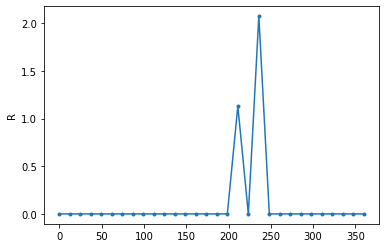

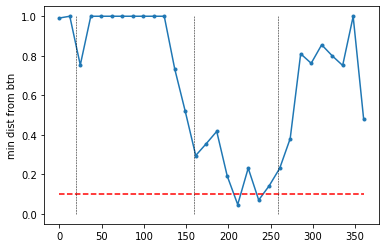

In [23]:
plt.plot(np.linspace(0,1,30)*360,Rs,marker='.')
plt.ylabel('R')
plt.show()

plt.plot(np.linspace(0,1,30)*360,dists,marker='.')
plt.plot([0,360],[0.1,0.1],ls='--',color='red')
for th in train_thetas:
    plt.plot([th/2/np.pi*360,th/2/np.pi*360],[0,1],ls='--',color='black',lw=0.5)
plt.ylabel('min dist from btn')
plt.show()

In [290]:
train_thetas

[2.52299293616753,
 0.969591500857559,
 1.140708900302102,
 3.0029161643653492,
 0.2310405821856491,
 0.6681815597950457,
 1.6523718323579166,
 0.6707626586301276,
 5.261259910639258,
 4.575919047460333,
 3.91796055546683,
 6.213717040553316,
 2.850080279385435,
 6.160270525171928,
 5.325837119068753,
 5.354466268829198,
 1.4029414667225832,
 5.5067320269454,
 3.988463532280372,
 5.016327747526899]

In [27]:
np.array(POSITION)[0,:]
print( np.sqrt( np.sum((np.array(POSITION)[50,:] - btn_test)**2) ) )

NameError: name 'POSITION' is not defined

In [ ]:
plt.figure()
plt.subplot(211)
plt.plot(POSITION[0,:])
plt.plot(POSITION[1,:])
plt.subplot(212)

plt.plot(context)

In [74]:
TIME_TEST = 1500

par['T'] = TIME_TEST
lttb.T = TIME_TEST

REWARDS = []

for rep in range(20):

    lttb.initialize(par)

    lttb.y_targ = np.zeros((lttb.O,lttb.T))

    targ_test = (np.random.rand(2)-.5)
    btn_test = (np.random.rand(2)-.5)

    trajectory = np.zeros((2,TIME_TEST-1))
    trajectory[:,0] = init

    env.reset (init = init, targ = targ_test, btn = btn_test)

    agen = init

    R = 0

    ACTIONS = []
    POSITION = np.zeros((2,TIME_TEST))

    state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

    #lttb.I_clock[:,0] *= 0

    #state, r, done, agen = env.step ([0,0])
    lttb.I_clock[:,0] = state#lttb.I_clock_collection[cont_index][:,0]

    lttb.cont = lttb.cont*0
    lttb.cont[0] = 1

    closed_loop = 1

    context = []

    for t in range (TIME_TEST-2):

        if closed_loop:
            lttb.I_clock[:,lttb.t+1] = state
            if np.sqrt( np.sum((agen - btn_test)**2) ) < 0.1:

                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1

        else:
            lttb.I_clock[:,lttb.t+1] = lttb.I_clock_collection[cont_index][:,lttb.t+1]
            if t == tb:
                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1

        context.append(lttb.cont)

        lttb.step (apicalFactor = 0)
        action = lttb.Jout@lttb.B_filt[:,t]
        ACTIONS.append(action)

        state, r, done, agen = env.step (action)

        POSITION[:,t] = agen
        R = max (R, r)

        if np.sqrt( np.sum((agen - targ_test)**2) ) < 0.1:
            done = 1

        if done: break
            
    REWARDS.append(R)

    print('R = ' + str(R))

    


R = 0
R = 0
R = 0
R = 0
R = 4.626371807823789
R = 0
R = 10.341577828430156
R = 10.271286194102471
R = 0
R = 5.636280050593238
R = 0
R = 0
R = 0
R = 0
R = 0
R = 4.796671672409694
R = 0
R = 10.042919213210986
R = 0
R = 0


Text(0.5, 0, 'Reward')

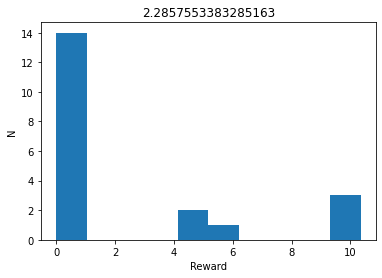

In [75]:
plt.hist(REWARDS)
plt.title(np.array(REWARDS).mean())
plt.ylabel("N")
plt.xlabel("Reward")